In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

## Gaussian analysis tutorial 

Infomation theory has historically been focused on discrete distributions, such as alphabets, word corpuses, etc. But in theory it can be applied to continuous probability ditsributions as well. The differential entropy was given by Shannon as:

\begin{align}
H^{\mathcal{N}}(X) = -\int dx P(x)\log P(x)
\end{align}

The differential entropy is different from the discrete entropy as it can be negative, although it is still an expected value over a distribution of local entropies: $h^{\mathcal{N}}(x) = -\log P(x)$.

If the data in question was generated by a Gaussian distribution, the differential entropy has a closed form:

\begin{align}
    H^{\mathcal{N}}(X) = \log (\sigma\sqrt{2\pi e})
\end{align}

If the disribution is multivariate, the covariance matrix $\Sigma$ defines the joint entropy:

\begin{align}
H^{\mathcal{N}}(\textbf{X}) = \frac{\log\big[(2\pi e)^{N}|\Sigma|\big]}{2}
\end{align}

Where $|\Sigma|$ is the determinant of the covariance matrix. 

From these identities it is possible to reconstruct all other information-theoretic functions.

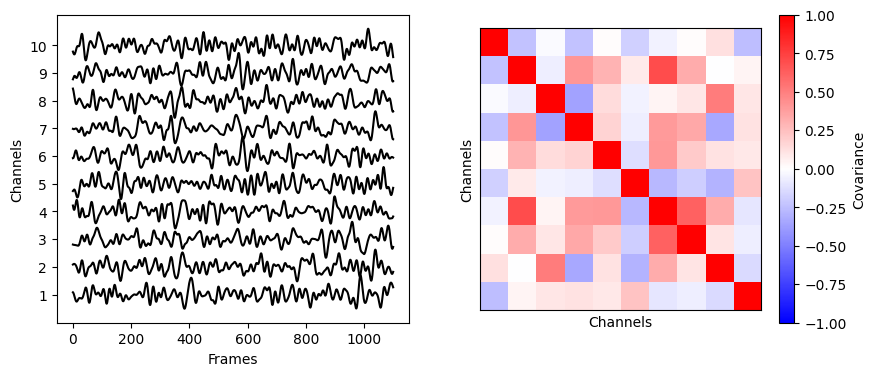

In [4]:
# Begin by loading some example data. 
# These are 10 channels from an fMRI scan of a human brain.

data:np.ndarray = pd.read_csv("bold.csv", header=None).values
cov:np.ndarray = np.cov(data, ddof=0.0) # The covariance matrix. 

N:int = data.shape[0]

fig = plt.figure(figsize=(10,4), dpi=100)
ax1 = fig.add_subplot(1,2,1)
for i in range(N):
    ax1.plot(data[i] + (i*5), color="k")
ax1.set_yticks([i*5 for i in range(N)])
ax1.set_yticklabels([i+1 for i in range(N)])
ax1.set_xlabel("Frames")
ax1.set_ylabel("Channels")

ax2 = fig.add_subplot(1,2,2)
imshow = ax2.imshow(cov, vmin=-1, vmax=1, cmap="bwr")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel("Channels")
ax2.set_ylabel("Channels")

plt.colorbar(imshow, label="Covariance")

### Basic Shannon quantities

In [4]:
from syntropy.gaussian.shannon import differential_entropy, conditional_entropy, mutual_information, conditional_mutual_information

# We can operate on the covariance matrix directly, computing a variety of statistics:

# You can compute the differential entropy of the whole matrix:
h = differential_entropy(cov=cov)
print(f"H(cov) = {h} nat")

# You can also specify a subset you want the entropy of. 
inputs = (0,1,2)
h1 = differential_entropy(cov=cov, inputs=inputs)
print(f"H({inputs}) = {h1} nat")
print(" ")
# You can condition the entropy of one set of variables on another. 
conditioning = (3,4)
c = conditional_entropy(inputs, conditioning, cov)
print(f"H({inputs}|{conditioning})             = {c} nat")

# We can confirm that this matches the definition of conditional entropy:
h_union = differential_entropy(cov, inputs = inputs + conditioning)
h_conditioning = differential_entropy(cov, inputs = conditioning)

print(f"H({inputs}U{conditioning}) - H({conditioning}) = {h_union-h_conditioning} nat")

H(cov) = 12.568878555812411 nat
H((0, 1, 2)) = 4.224074902314058 nat
 
H((0, 1, 2)|(3, 4))             = 3.980795843832389 nat
H((0, 1, 2)U(3, 4)) - H((3, 4)) = 3.980795843832389 nat


For two univariate random variables, the mutual information is a function of the Pearson correlation coefficient:

\begin{align}
I^{\mathcal{N}}(X;Y) = \frac{-\log(1-r^{2})}{2}
\end{align}

And for multivariate $\textbf{X}$ and $\textbf{Y}$:

\begin{align}
I^{\mathcal{N}}(\textbf{X};\textbf{Y}) = \frac{1}{2}\log\frac{|\Sigma_{\textbf{X}}||\Sigma_{\textbf{Y}}|}{|\Sigma_{\textbf{XY}}|}
\end{align}

In [3]:
# We can compute the mutual information between arbitrary subsets
x, y = (0,1,2), (3,4)
mi = mutual_information(x, y, cov)
print(f"I({x};{y}) = {mi} nat")

x, y = (0,), (1,)
mi = mutual_information(x, y, cov)
print(f"I({x};{y})        = {mi} nat")

I((0, 1, 2);(3, 4)) = 0.24327905848166823 nat
I((0,);(1,))        = 0.029604895179489714 nat


In [4]:
# And the conditional mutual information as well
x, y, z = (0,1,2), (3,4), (5,6)

cmi = conditional_mutual_information(x, y, z, cov)
print(f"I({x};{y}|{z})                       = {cmi} nat")

# This matches sthe definition of conditional mutual information:
mi = mutual_information(x, y+z, cov) - mutual_information(x, z, cov)
print(f"I({x};{y}U{z}) - I({x};{z}) = {mi} nat")

I((0, 1, 2);(3, 4)|(5, 6))                       = 0.15166855801200985 nat
I((0, 1, 2);(3, 4)U(5, 6)) - I((0, 1, 2);(5, 6)) = 0.15166855801201035 nat


## Multivariate information quantities

Details on all of the multivariate information measures are presented in the ``example_discrete.ipynb`` tutorial, however we should note that a closed-form estimator for the total correlation for Gaussian systems exists:

\begin{align}
TC^{\mathcal{N}}(\textbf{X}) = \frac{-\log |R_{\textbf{X}}|}{2}
\end{align}

Where $R_{\textbf{X}}$ is the correlation matrix of $\textbf{X}$.

All of the remaining multivariate measures except the co-information can be written out in terms of the total correlation:

\begin{align}
\Sigma(\textbf{X}) &= N\times TC(\textbf{X}) - \sum_{i=1}^{N}TC(\textbf{X}^{-i}) \\
DTC(\textbf{X}) &= (N-1)\times TC(\textbf{X}) - \sum_{i=1}^{N}TC(\textbf{X}^{-i}) \\
\Omega(\textbf{X}) &= -\big[(N-2)\times TC(\textbf{X}) - \sum_{i=1}^{N}TC(\textbf{X}^{-i})\big]
\end{align}

Note that, due to an unfortunate conflict of notation, $\Sigma$ can refer to the S-information when it is a function and the covariance matrix when it in an object.


In [5]:
from syntropy.gaussian.multivariate_mi import total_correlation, dual_total_correlation, o_information, s_information, description_complexity

tc = total_correlation(cov)
dtc = dual_total_correlation(cov)
oinfo = o_information(cov)
sinfo = s_information(cov)
c = description_complexity(cov)

print(f"TC(cov) = {tc} nat")
print(f"DTC(cov) = {dtc} nat")
print(f"O(cov) = {oinfo} nat")
print(f"S(cov) = {sinfo} nat")
print(f"C(cov) = {c} nat")

# We can also subset the covariance matrices with the `inputs` argument
inputs = (0,1,2,3)

tc = total_correlation(cov, inputs)
dtc = dual_total_correlation(cov, inputs)
oinfo = o_information(cov, inputs)
sinfo = s_information(cov, inputs)
c = description_complexity(cov, inputs)

print(" ") 

print(f"TC{inputs}) = {tc} nat")
print(f"DTC({inputs}) = {dtc} nat")
print(f"O({inputs}) = {oinfo} nat")
print(f"S({inputs}) = {sinfo} nat")
print(f"C({inputs}) = {c} nat")


TC(cov) = 1.6205067762343162 nat
DTC(cov) = 1.4554808365269682 nat
O(cov) = 0.16502593970734836 nat
S(cov) = 3.075987612761285 nat
C(cov) = 0.14554808365269684 nat
 
TC(0, 1, 2, 3)) = 0.2176068250989591 nat
DTC((0, 1, 2, 3)) = 0.20624827987228966 nat
O((0, 1, 2, 3)) = 0.011358545226669403 nat
S((0, 1, 2, 3)) = 0.4238551049712488 nat
C((0, 1, 2, 3)) = 0.051562069968072416 nat


## Local information quantities

When dealing with real-valued variables, syntropy has a dedicated collection of functions to operate on local variables (instead of returning pointwise and average values together, as is done with discrete random variables). Local variables can be computed for basic measures, multivariate measures, and partial information/entropy atoms. 

Local variables are returned as Numpy arrays, with one value for every sample in the initial dataset. 

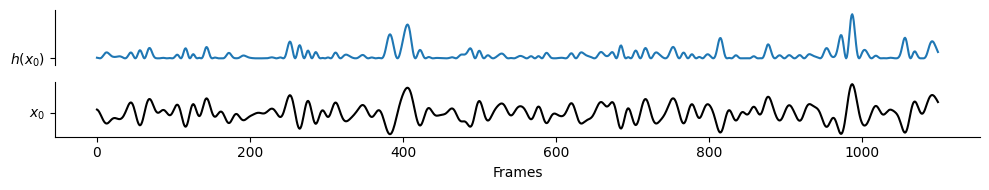

In [5]:
from syntropy.gaussian.shannon import local_differential_entropy, local_mutual_information

# Local versions of all the above measures exist, with essentially the same syntax. 

lh = local_differential_entropy(data[0])
fig = plt.figure(dpi=100, figsize=(10,2))

ax1 = fig.add_subplot(2,1,1)
ax1.plot(lh)
ax1.set_yticks([1])
ax1.set_yticklabels([r"$h(x_{0})$"])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_ylim([-0,7.5])

ax2 = fig.add_subplot(2,1,2)
ax2.plot(data[0], color="k")
ax2.set_yticks([0])
ax2.set_yticklabels([r"$x_{0}$"])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel("Frames")

fig.tight_layout()


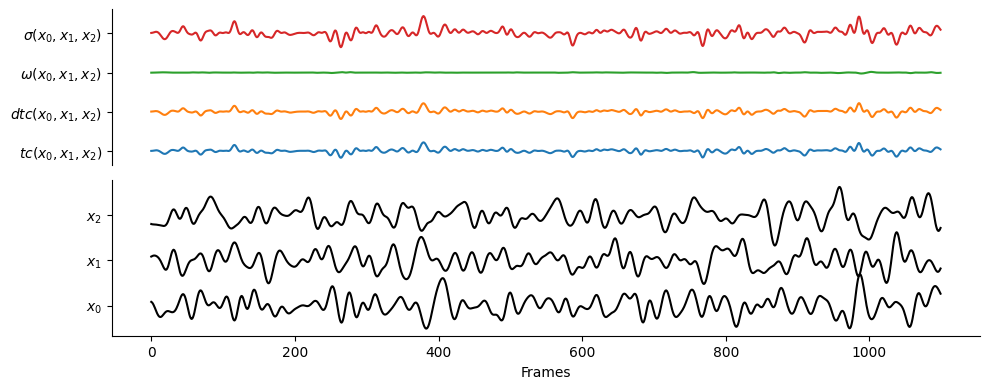

In [6]:
from syntropy.gaussian.multivariate_mi import local_total_correlation, local_dual_total_correlation, local_s_information, local_o_information

inputs = (0,1,2)

ltc = local_total_correlation(data, inputs=inputs)
ldtc = local_dual_total_correlation(data, inputs=inputs)
lo = local_o_information(data, inputs=inputs)
ls = local_s_information(data, inputs=inputs)

fig = plt.figure(dpi=100, figsize=(10,4))

ax1 = fig.add_subplot(2,1,1)

ax1.plot(ltc) 
ax1.plot(ldtc + 5)
ax1.plot(lo + 10)
ax1.plot(ls + 15)
ax1.set_yticks([0,5,10,15])
ax1.set_yticklabels([
    r"$tc(x_0, x_1, x_2)$",
    r"$dtc(x_0, x_1, x_2)$",
    r"$\omega(x_0, x_1, x_2)$",
    r"$\sigma(x_0, x_1, x_2)$",
                    ])

ax1.set_xticks([])
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax2 = fig.add_subplot(2,1,2)
ax2.plot(data[inputs[0]], color="k")
ax2.plot(data[inputs[1]]+5, color="k")
ax2.plot(data[inputs[2]]+10, color="k")
ax2.set_xlabel("Frames")
ax2.set_yticks([0, 5, 10])
ax2.set_yticklabels([r"$x_{0}$", r"$x_{1}$", r"$x_{2}$"])
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

fig.tight_layout()

## Multivariate information decomposition

Finally, the partial information decomposition, partial entropy decomposition, and generalized information decomposition can also be computed with Gaussian estimators, using the h/i_min function from Finn and Lizier.

Both average and local values are available.

In [8]:
from syntropy.gaussian.decompositions import partial_information_decomposition, partial_entropy_decomposition, generalized_information_decomposition

inputs = (0,1)
target = (2,)

# We can do PID, PED, and GID, all using the minimum local entropy funcction from Finn and Lizier

# Partial entropy decomposition
ptw, avg = partial_information_decomposition(inputs, target, data, cov)
mi = mutual_information(inputs, target, cov)

print(f"Red({inputs};{target}) = {avg[((0,),(1,))]} nat")
print(f"Unq({(inputs[0],)};{target})   = {avg[((0,),)]} nat")
print(f"Red({(inputs[1],)};{target})   = {avg[((1,),)]} nat")
print(f"Syn({inputs};{target}) = {avg[((0,1,),)]} nat")
print(" ")

# We can make sure the atoms all sum up to the correct value. 
print(f"Sum(PI-atoms)  = {sum(avg.values())}")
print(f"I({inputs};{target}) = {mi}")

print(" ")
# And we can extract the expected higher-order mutual informations. 
o = o_information(cov, inputs + target)
print(f"O-information({inputs + target})            = {o} nat")
print(f"Red({inputs};{target}) - Syn({inputs};{target}) = {avg[((0,),(1,))] - avg[((0,1,),)]} nat")

Red((0, 1);(2,)) = -0.0049660012244326845 nat
Unq((0,);(2,))   = 0.005156900055362774 nat
Red((1,);(2,))   = 0.007400921211967683 nat
Syn((0, 1);(2,)) = -0.004455905272572599 nat
 
Sum(PI-atoms)  = 0.0031359147703251744
I((0, 1);(2,)) = 0.0031359147703226902
 
O-information((0, 1, 2))            = -0.0005102086017174032 nat
Red((0, 1);(2,)) - Syn((0, 1);(2,)) = -0.0005100959518600859 nat


The PID, PED, and GID also all retun local values as well.

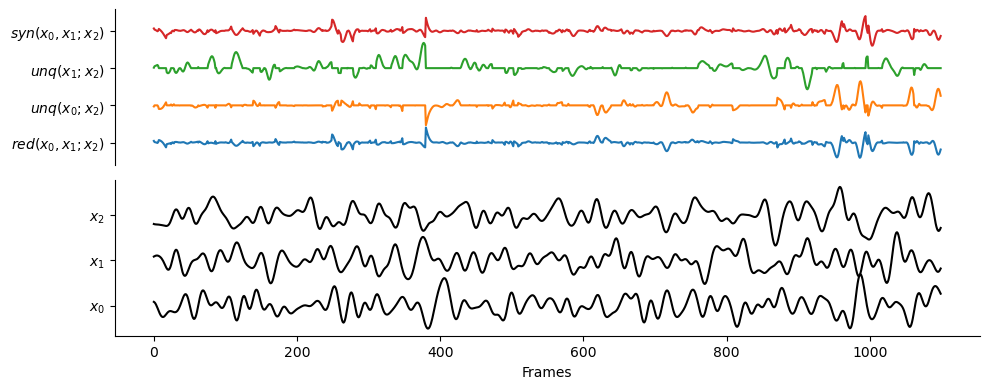

In [9]:
# Using the ptw object created above. 

fig = plt.figure(dpi=100, figsize=(10,4))

ax1 = fig.add_subplot(2,1,1)

ax1.plot(ptw[((0,),(1,))][0]) 
ax1.plot(ptw[((0,),)][0] + 1/2)
ax1.plot(ptw[((1,),)][0] + 2/2)
ax1.plot(ptw[((0,1,),)][0] + 3/2)
ax1.set_yticks([0, 1/2, 2/2, 3/2])
ax1.set_yticklabels([
    r"$red(x_0, x_1 ; x_2)$",
    r"$unq(x_0 ; x_2)$",
    r"$unq(x_1 ; x_2)$",
    r"$syn(x_0, x_1 ; x_2)$",
                    ])

ax1.set_xticks([])
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.spines["right"].set_visible(False)

ax2 = fig.add_subplot(2,1,2)
ax2.plot(data[inputs[0]], color="k")
ax2.plot(data[inputs[1]]+5, color="k")
ax2.plot(data[target[0]]+10, color="k")
ax2.set_xlabel("Frames")
ax2.set_yticks([0, 5, 10])
ax2.set_yticklabels([r"$x_{0}$", r"$x_{1}$", r"$x_{2}$"])
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

fig.tight_layout()

Finally, syntropy can compute the Kullback-Leibler divergence (the information gained when updating ones beliefs from a prior distribution to a posterior distribution. In this case, both distributions are parameterized by covariance matrices.

The generalized information decomposition (GID) decomposes KL divergence in the same fashion as the PID and PED.

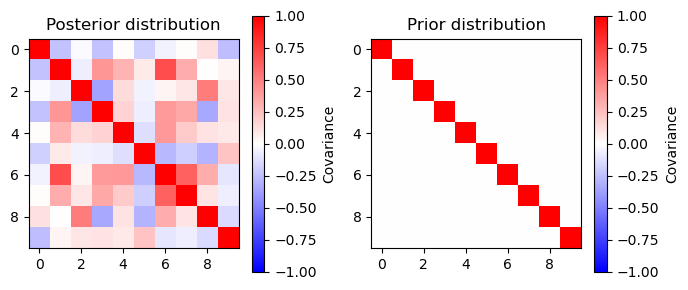

In [23]:
from syntropy.gaussian.shannon import kullback_leibler_divergence

# For the generalized information decomposition, you need to define a prior and a posterior, 
# A natural prior is maximum entropy:

prior = np.eye(cov.shape[0])

fig = plt.figure(dpi=100, figsize=(7,3))
ax1 = fig.add_subplot(1,2,1)
is1 = ax1.imshow(cov, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(is1, label="Covariance")
ax1.set_title("Posterior distribution")

ax2 = fig.add_subplot(1,2,2)
is2 = ax2.imshow(prior, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(is2, label="Covariance")
ax2.set_title("Prior distribution")


fig.tight_layout()

In [37]:
ptw, avg = generalized_information_decomposition((0,1), data, cov, prior)

# In the case of two Gaussian variables, all of the information is in the synergy atom and it is equivalent to the 
# mutual information. 
print(f"Syn((0,);(1,)) = {avg[((0,1),)]} nat")
print(f"I((0,);(1,))   = {mutual_information((0,),(1,), cov)} nat")

Syn((0,);(1,)) = 0.029604895179492507 nat
I((0,);(1,))   = 0.029604895179489714 nat
